### Random Forest를 partial linear 모형으로 세워서 vix를 예측해보기
- $y_{t} = y_{t-1} + y_{t-1}^{weekly} + y_{t-1}^{monthly} + y_{t-1}^{quarterly} + f(X_{t-1})$
    - $y_{t-1}^{weekly} = \frac{1}{5}\sum^{5}_{j=1}y_{t-j}$
    - $y_{t-1}^{monthly} = \frac{1}{22}\sum^{22}_{j=1}y_{t-j}$
- random forest의 경우 default value로 진행하기
- 동일하게 rolling으로 진행
- random seed를 하나로 고정하고 진행 → 나의 경우 42

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname = "c:/windows/fonts/malgun.ttf").get_name()
rc('font', family = font_name)
rcParams["axes.unicode_minus"] = False

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.ensemble import RandomForestRegressor
import xgboost
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle

#### Import data


In [16]:
# Line 7~16
df = pd.read_excel("../data/dataset_HARX(14).xlsx")
df = df.iloc[66:, :]
date = df["Code"].to_numpy() # The date
df.set_index(["Code"], inplace = True)
df = df.iloc[:5740, :] # to 1990-04-06 ~ 2013-01-15
                    # Fernandes et al.(2014) : 1990-04-05 ~ 2013-01-15
                    # But some values are NaN at 1990-04-05
                    # So I dropped 1990-04-05 #TODO: 해당 업은 아래 `run_pl_rf`에서 수행하도록 바꿨음. Forecast horizon을 맞추기 위해서
                                                # 최종적으로 forecast horizon은 Fernandes와 동일함
data = df.to_numpy() # To matrix
# data = data[66:, :] # obsolete line if dropna performed correctly # TODO: 위의 TODO 주석으로 인해서 이 부분은 주석처리함

In [17]:
df.head(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
1990-04-05,3.054473,3.055005,3.021329,2.998303,3.094873,-0.001056,-0.000176,0.014902,0.008252,-0.054152,...,NaN,-0.007446,-0.025950,-0.015053,-0.009059,-0.087096,NaN,0.54,0.85,-0.000665
1990-04-06,3.080073,3.074592,3.027489,3.004229,3.097588,-0.001909,0.000412,0.008445,0.009246,-0.053473,...,-0.054152,-0.001156,-0.017853,-0.030413,-0.028914,-0.091889,-0.163882,0.55,0.84,-0.000785


In [18]:
df.tail(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
2013-01-14,2.604170,2.607063,2.654235,2.774609,2.796113,-0.000931,0.005995,0.047518,0.029562,0.006652,...,0.007261,-0.000046,-0.002775,0.005036,0.029173,0.089385,0.019972,1.82,0.92,-0.002825
2013-01-15,2.606387,2.606033,2.625725,2.767197,2.794462,0.001128,0.010370,0.031846,0.030242,0.011242,...,0.006652,-0.000935,0.006180,0.010143,0.036124,0.092881,0.046308,1.81,0.93,-0.000503


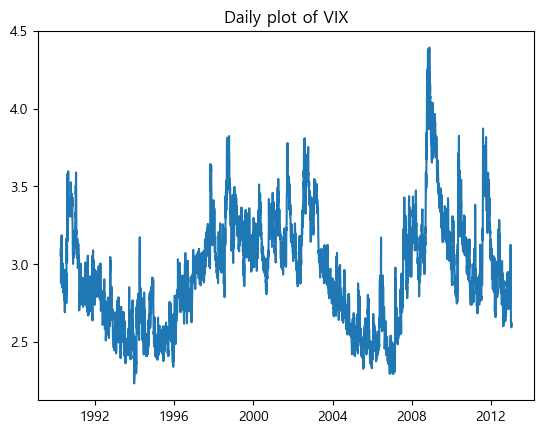

In [19]:
# plot vix
plt.plot(df["lnVIX"])
plt.title("Daily plot of VIX")
plt.show()

#### set the params for forecasting

In [20]:
npred = 3240

random_state = 42

params_for_rf = {"n_estimators" : 100, "random_state" : random_state}
params_for_xgb = {"tree_method" : "exact", "random_state" : random_state}

linear_variables = ["lnVIX", "HAR_5day", "HAR_10day", "HAR_22day", "HAR_66day"]
nonlinear_variables = list(df.columns[5:])
target_variable = "lnVIX"

# lag = 1

#### Perform the forecasting

In [21]:
# tmp_data = df.loc[date_window]

# # perform dropna due to 1990-04-05 / at that days, some variables contain np.nan
# tmp_data.dropna(inplace = True)

# # update date_window in case of dropna
# date_window = date_window[np.isin(date_window, tmp_data.index)]

# # set the X and Y
# Y = tmp_data.loc[:, target_variable]
# X = tmp_data.loc[:, linear_variables + nonlinear_variables]

# # set the target X and y
# X_window = date_window[:-lag]
# y_window = date_window[lag:]

# X_train = X.loc[X_window]
# y_train = Y.loc[y_window]

# # split the X to linear and nonlinear
# X_linear_train = X_train.loc[:, linear_variables]
# X_nonlinear_train = X_train.loc[:, nonlinear_variables]

# # Set the window for test
# X_test_window = date_window[-lag]
# y_test_window = date[(np.where(date == pd.to_datetime(X_test_window))[0] + lag)[0]]

# X_linear_test = tmp_data.loc[X_test_window:X_test_window, linear_variables]
# X_nonlinear_test = tmp_data.loc[X_test_window:X_test_window, nonlinear_variables]

# # Apply the Robison's estimator
# ## 1. extract linear residual
# RF_X_linear_residual = []
# XGB_X_linear_residual = []

# for idx in range(X_linear_train.shape[1]):
    
#     tmp_X_linear = X_linear_train.iloc[:, idx:idx+1]

#     # Random Forest
#     RF_for_residual_X_linear = RandomForestRegressor(**params_for_rf)
#     RF_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

#     tmp_RF_X_linear_residual = tmp_X_linear.iloc[:, 0] - RF_for_residual_X_linear.predict(X_nonlinear_train)
#     RF_X_linear_residual.append(tmp_RF_X_linear_residual)

#     # XGBoost
#     XGB_for_residual_X_linear = xgboost.XGBRegressor(**params_for_xgb)
#     XGB_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

#     tmp_XGB_X_linear_residual = tmp_X_linear.iloc[:, 0] - XGB_for_residual_X_linear.predict(X_nonlinear_train)
#     XGB_X_linear_residual.append(tmp_XGB_X_linear_residual)

# RF_X_linear_residual = pd.concat(RF_X_linear_residual, axis = 1)
# XGB_X_linear_residual = pd.concat(XGB_X_linear_residual, axis = 1)

# ## 2. extract y residual
# # Random Forest
# RF_for_residual_y = RandomForestRegressor(**params_for_rf)
# RF_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
# RF_y_residual = y_train - RF_for_residual_y.predict(X_nonlinear_train)

# # XGBoost
# XGB_for_residual_y = xgboost.XGBRegressor(**params_for_xgb)
# XGB_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
# XGB_y_residual = y_train - XGB_for_residual_y.predict(X_nonlinear_train)

# ## 3. Get the beta
# RF_beta = pd.DataFrame(index = X_window, columns = RF_X_linear_residual.columns)
# XGB_beta = pd.DataFrame(index = X_window, columns = XGB_X_linear_residual.columns)

# RF_OLS = sm.OLS(endog = RF_y_residual.values, exog = RF_X_linear_residual.values).fit()
# XGB_OLS = sm.OLS(endog = XGB_y_residual.values, exog = XGB_X_linear_residual.values).fit()

# RF_beta = RF_OLS.params
# XGB_beta = XGB_OLS.params

# ## 4. Estimate RandomForest and XGBoost
# RF_residual = y_train.ravel() - (X_linear_train @ RF_beta).ravel()
# XGB_residual = y_train.ravel() - (X_linear_train @ XGB_beta).ravel()

# RF_ = RandomForestRegressor(**params_for_rf)
# RF_.fit(X = X_nonlinear_train, y = RF_residual)

# XGB_ = xgboost.XGBRegressor(**params_for_xgb)
# XGB_.fit(X = X_nonlinear_train, y = XGB_residual)

# ## 5. Get the prediction
# RF_pred = X_linear_test @ RF_beta + RF_.predict(X_nonlinear_test)
# XGB_pred = X_linear_test @ XGB_beta + XGB_.predict(X_nonlinear_test)

# RF_pred.index = [y_test_window]
# XGB_pred.index = [y_test_window]

# RF_pred.name = "VIX_pred_RF"
# XGB_pred.name = "VIX_pred_XGB"

In [22]:
"""define the func `run_pl_rf`"""
def run_pl_rf(date_window, date, lag, df, linear_variables, nonlinear_variables, target_variable):

    tmp_data = df.loc[date_window]

    # perform dropna due to 1990-04-05 / at that days, some variables contain np.nan
    tmp_data.dropna(inplace = True)

    # update date_window in case of dropna
    date_window = date_window[np.isin(date_window, tmp_data.index)]

    # set the X and Y
    Y = tmp_data.loc[:, target_variable]
    X = tmp_data.loc[:, linear_variables + nonlinear_variables]

    # set the target X and y
    X_window = date_window[:-lag]
    y_window = date_window[lag:]

    X_train = X.loc[X_window]
    y_train = Y.loc[y_window]

    # split the X to linear and nonlinear
    X_linear_train = X_train.loc[:, linear_variables]
    X_nonlinear_train = X_train.loc[:, nonlinear_variables]

    # Set the window for test
    X_test_window = date_window[-lag]
    y_test_window = date[(np.where(date == pd.to_datetime(X_test_window))[0] + lag)[0]]

    X_linear_test = tmp_data.loc[X_test_window:X_test_window, linear_variables]
    X_nonlinear_test = tmp_data.loc[X_test_window:X_test_window, nonlinear_variables]

    # Apply the Robison's estimator
    ## 1. extract linear residual
    RF_X_linear_residual = []
    XGB_X_linear_residual = []

    for idx in range(X_linear_train.shape[1]):
        
        tmp_X_linear = X_linear_train.iloc[:, idx:idx+1]

        # Random Forest
        RF_for_residual_X_linear = RandomForestRegressor(**params_for_rf)
        RF_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

        tmp_RF_X_linear_residual = tmp_X_linear.iloc[:, 0] - RF_for_residual_X_linear.predict(X_nonlinear_train)
        RF_X_linear_residual.append(tmp_RF_X_linear_residual)

        # XGBoost
        XGB_for_residual_X_linear = xgboost.XGBRegressor(**params_for_xgb)
        XGB_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

        tmp_XGB_X_linear_residual = tmp_X_linear.iloc[:, 0] - XGB_for_residual_X_linear.predict(X_nonlinear_train)
        XGB_X_linear_residual.append(tmp_XGB_X_linear_residual)

    RF_X_linear_residual = pd.concat(RF_X_linear_residual, axis = 1)
    XGB_X_linear_residual = pd.concat(XGB_X_linear_residual, axis = 1)

    ## 2. extract y residual
    # Random Forest
    RF_for_residual_y = RandomForestRegressor(**params_for_rf)
    RF_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
    RF_y_residual = y_train - RF_for_residual_y.predict(X_nonlinear_train)

    # XGBoost
    XGB_for_residual_y = xgboost.XGBRegressor(**params_for_xgb)
    XGB_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
    XGB_y_residual = y_train - XGB_for_residual_y.predict(X_nonlinear_train)

    ## 3. Get the beta
    RF_beta = pd.DataFrame(index = X_window, columns = RF_X_linear_residual.columns)
    XGB_beta = pd.DataFrame(index = X_window, columns = XGB_X_linear_residual.columns)

    RF_OLS = sm.OLS(endog = RF_y_residual.values, exog = RF_X_linear_residual.values).fit()
    XGB_OLS = sm.OLS(endog = XGB_y_residual.values, exog = XGB_X_linear_residual.values).fit()

    RF_beta = RF_OLS.params
    XGB_beta = XGB_OLS.params

    ## 4. Estimate RandomForest and XGBoost
    RF_residual = y_train.ravel() - (X_linear_train @ RF_beta).ravel()
    XGB_residual = y_train.ravel() - (X_linear_train @ XGB_beta).ravel()

    RF_ = RandomForestRegressor(**params_for_rf)
    RF_.fit(X = X_nonlinear_train, y = RF_residual)

    XGB_ = xgboost.XGBRegressor(**params_for_xgb)
    XGB_.fit(X = X_nonlinear_train, y = XGB_residual)

    ## 5. Get the prediction
    RF_pred = X_linear_test @ RF_beta + RF_.predict(X_nonlinear_test)
    XGB_pred = X_linear_test @ XGB_beta + XGB_.predict(X_nonlinear_test)

    RF_pred.index = [y_test_window]
    XGB_pred.index = [y_test_window]

    RF_pred.name = "VIX_pred_RF"
    XGB_pred.name = "VIX_pred_XGB"

    return RF_pred, XGB_pred, RF_beta, XGB_beta

In [24]:
from functools import reduce

RF_prediction_dict = {}
XGB_prediction_dict = {}

RF_betas_dict = {}
XGB_betas_dict = {}

RF_rmse_dict = {}
XGB_rmse_dict = {}

RF_mae_dict = {}
XGB_mae_dict = {}

for lag in [1, 5, 10, 22][:]:

    print("{0:=^30}".format(f" Start {lag}-ahead forecast "))

    RF_prediction = []
    XGB_prediction = []

    RF_betas = []
    XGB_betas = []
    for i in range(npred, 0, -1)[:]:
        
        date_window = date[(npred - i):(data.shape[0] - i)]

        pred_idx = npred - i

        # perform the forecast
        RF_pred, XGB_pred, RF_beta, XGB_beta = run_pl_rf(date_window, date, lag, df
                                                        , linear_variables, nonlinear_variables
                                                        , target_variable)
        
        RF_prediction.append(RF_pred)
        XGB_prediction.append(XGB_pred)

        RF_betas.append(RF_beta)
        XGB_betas.append(XGB_beta)

        if (pred_idx+1)%20 == 0:
            print(f"Forecast #{pred_idx}-th sample is finished.")

    # to DataFrame
    RF_prediction = pd.concat(RF_prediction).to_frame()
    XGB_prediction = pd.concat(XGB_prediction).to_frame()

    RF_betas = pd.DataFrame(RF_betas, columns = linear_variables, index = RF_prediction.index)
    XGB_betas = pd.DataFrame(XGB_betas, columns = linear_variables, index = XGB_prediction.index)

    # change the column name to identify from which lag
    RF_prediction.columns = [RF_prediction.columns[0] + f"_lag{lag}"]
    XGB_prediction.columns = [XGB_prediction.columns[0] + f"_lag{lag}"]

    # get the real value to calculate errors
    real_value = df[[target_variable]].loc[RF_prediction.index]

    # merge the prediction
    result = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True)
                                        , [real_value, RF_prediction, XGB_prediction])

    # calculate errors
    RF_rmse = mean_squared_error(result["lnVIX"], result[f"VIX_pred_RF_lag{lag}"], squared = False)
    XGB_rmse = mean_squared_error(result["lnVIX"], result[f"VIX_pred_XGB_lag{lag}"], squared = False)

    RF_mae = mean_absolute_error(result["lnVIX"], result[f"VIX_pred_RF_lag{lag}"])
    XGB_mae = mean_absolute_error(result["lnVIX"], result[f"VIX_pred_XGB_lag{lag}"])

    # Save the result
    RF_prediction_dict[lag], XGB_prediction_dict[lag] = RF_prediction, XGB_prediction
    RF_betas_dict[lag], XGB_betas_dict[lag] = RF_betas, XGB_betas
    RF_rmse_dict[lag], XGB_rmse_dict[lag] = RF_rmse, XGB_rmse
    RF_mae_dict[lag], XGB_mae_dict[lag] = RF_mae, XGB_mae

=== Start 1-ahead forecast ===
Forecast #3240-th sample is finished.
=== Start 5-ahead forecast ===
Forecast #3240-th sample is finished.
== Start 10-ahead forecast ===
Forecast #3240-th sample is finished.
== Start 22-ahead forecast ===
Forecast #3240-th sample is finished.


In [26]:
result_dict = {"RF_prediction" : RF_prediction_dict, "XGB_prediction" : XGB_prediction_dict
            , "RF_rmse" : RF_rmse_dict, "XGB_rmse" : XGB_rmse_dict
            , "RF_mae" : RF_mae_dict, "XGB_mae" : XGB_mae_dict
            , "RF_betas" : RF_betas_dict, "XGB_betas" : XGB_betas_dict}

In [34]:
from pathlib import Path

data_path = str(Path.cwd().parent / "data")
result_path = str(Path.cwd().parent / "result")

In [38]:
import pickle

with open(f"{result_path}/vix-forecast-py_241003.pkl", "wb") as f:
    pickle.dump(result_dict, f)